In [1]:
import gmsh
import pyvista
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm.autonotebook

from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological,
                        locate_dofs_geometrical, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector,
                               create_vector, create_matrix, set_bc)
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import VTXWriter, distribute_entity_data, gmshio
from dolfinx.mesh import create_mesh, meshtags_from_entities
from basix.ufl import element as basix_element
from dolfinx.plot import vtk_mesh
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction, conditional,le,ge,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system,SpatialCoordinate)


In [2]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print the result from the engines
    print("\n".join(r))

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Hello World from rank 0. total ranks=4
Hello World from rank 1. total ranks=4
Hello World from rank 2. total ranks=4
Hello World from rank 3. total ranks=4
Stopping engine(s): 1728227526
engine set stopped 1728227526: {'exit_code': 0, 'pid': 7894, 'identifier': 'ipengine-1728227525-74ck-1728227526-7844'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 7863, 'identifier': 'ipcontroller-1728227525-74ck-7844'}


In [3]:
# Some Vars for MPI
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh_file = "mesh_with_obstacle_05_25.msh"
# meshing rate values for disc d and box b 
d_in, d_out, b_in, b_out = 0.05, 0.25, 0.1, 0.5
filename = "mfr_l2"

pressure = 8

t = 0
T = 6
num_steps = 1500
dt = T / num_steps

# Initialize Gmsh
if mesh_comm.rank == model_rank:# Mass flow rate at the beginning of the domain

    # Initialize Gmsh
    gmsh.initialize()
    gmsh.model.add("Rectangle_with_Obstacle_OCC")
    
    # Define dimensions of the rectangle
    canal_length = 2.2  # length of the rectangle
    canal_height = .41   # height of the rectangle
    
    # Define obstacle dimensions (circular obstacle), now at the upper wall
    obstacle_center_x = 1.1  # x position of the obstacle center
    obstacle_center_y = canal_height  # y position of the obstacle center (at upper wall)
    obstacle_radius = .05    # radius of the circular obstacle
    
    # Create the rectangle (using gmsh.model.occ)
    canal = gmsh.model.occ.addRectangle(0, 0, 0, canal_length, canal_height)
    
    # Create the circular obstacle (using gmsh.model.occ)
    obstacle = gmsh.model.occ.addDisk(obstacle_center_x, obstacle_center_y, 0, obstacle_radius, obstacle_radius)
    
    # Cut the circular obstacle out of the rectangular surface
    fluid_domain, _ = gmsh.model.occ.cut([(2, canal)], [(2, obstacle)])

    gmsh.model.occ.synchronize()
    
    # Define physical groups
    fluid_marker = 1
    inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    
    # Fluid domain (2D)
    gmsh.model.addPhysicalGroup(2, [fluid_domain[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(2, fluid_marker, "Fluid")
    
    inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    inflow, outflow, walls, obstacle = [], [], [], []
    
    # Define a tolerance for comparing coordinates
    tol = 1e-6
    '''
    points = gmsh.model.getEntities(0)  # Get all points
    curves = gmsh.model.getEntities(1)  # Get all curves
    surfaces = gmsh.model.getEntities(2)  # Get all surfaces
    volumes = gmsh.model.getEntities(3)  # Get all volumes
    '''
    volumes = gmsh.model.getEntities(3)
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    # Iterate over each boundary and check its associated nodes' positions
    for boundary in boundaries:
        # Get the node tags for this boundary
        node_tags = gmsh.model.mesh.getNodes(boundary[0], boundary[1])[0]
        node_coords = gmsh.model.mesh.getNode(node_tags[0])[0]  # Get the first node's coordinates
    
        # Check if the boundary is the inflow (x = 0)
        if np.isclose(node_coords[0], 0.0, atol=tol):
            inflow.append(boundary[1])
        # Check if the boundary is the outflow (x = L)
        elif np.isclose(node_coords[0], L, atol=tol):
            outflow.append(boundary[1])
        # Check if the boundary is a wall (y = 0 or y = H)
        elif np.isclose(node_coords[1], 0.0, atol=tol) or np.isclose(node_coords[1], H, atol=tol):
            walls.append(boundary[1])
        # If none of the above, consider it part of the obstacle
        else:
            obstacle.append(boundary[1])

    # Assign physical groups to the identified boundaries
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")   

In [4]:
# --------------------------------------------------------------
# Step 1: Define mesh fields for a finer mesh around the obstacle
# --------------------------------------------------------------
if mesh_comm.rank == model_rank:
    # 1. Create a circular region around the obstacle for a dense mesh
    gmsh.model.mesh.field.add("Ball", 1)
    gmsh.model.mesh.field.setNumber(1, "Radius", obstacle_radius*1.3)  # Define a circular region of radius 2 units
    gmsh.model.mesh.field.setNumber(1, "XCenter", obstacle_center_x)  # X coordinate of the obstacle
    gmsh.model.mesh.field.setNumber(1, "YCenter", obstacle_center_y)  # Y coordinate (top wall)
    gmsh.model.mesh.field.setNumber(1, "VIn", d_in)   # Minimum element size inside the circular region
    gmsh.model.mesh.field.setNumber(1, "VOut", d_out)   # Maximum element size outside the circular region
    
    # 2. Refine the vertical part of the rectangle where the obstacle is located
    gmsh.model.mesh.field.add("Box", 2)
    gmsh.model.mesh.field.setNumber(2, "VIn", 0.1)  # Smaller mesh size inside the box
    gmsh.model.mesh.field.setNumber(2, "VOut", 0.5)  # Coarser mesh outside the box
    gmsh.model.mesh.field.setNumber(2, "XMin", obstacle_center_x - obstacle_radius)  # Start of the vertical region
    gmsh.model.mesh.field.setNumber(2, "XMax", obstacle_center_x + obstacle_radius)  # End of the vertical region
    gmsh.model.mesh.field.setNumber(2, "YMin", 0)    # Bottom of the rectangle
    gmsh.model.mesh.field.setNumber(2, "YMax", canal_height)  # Full height of the rectangle


In [5]:
# --------------------------------------------------------------
# Step 2: Set the background field to use the obstacle refinement
# --------------------------------------------------------------
if mesh_comm.rank == model_rank:
    gmsh.model.mesh.field.add("Min", 3)  # Combine fields to ensure the smallest element size is used
    gmsh.model.mesh.field.setNumbers(3, "FieldsList", [1, 2])
    
    # Set the combined field as the background mesh
    gmsh.model.mesh.field.setAsBackgroundMesh(3)

In [6]:
# --------------------------------------------------------------
# Step 3: Generate the mesh
# --------------------------------------------------------------
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")
    gmsh.write(mesh_file)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Ellipse)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.00056607s, CPU 0.0015s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.000463821s, CPU 0.000391s): 15 quads, 6 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.622471, min Q = 0.343157
Info    : Simple recombination completed (Wall 0.00171518s, CPU 0.001716s): 78 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.668381, min Q = 0.168265
Info    : Done meshing 2D (Wall 0.00313605s, CPU 0.003083s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 30%] Meshing 

In [7]:
# --------------------------------------------------------------
# Step 4: Visualize the mesh using Matplotlib
# --------------------------------------------------------------
# Retrieve nodes and elements from Gmsh for visualization
nodes = gmsh.model.mesh.getNodes()
node_coords = np.array(nodes[1]).reshape((-1, 3))  # Reshape nodes to [num_nodes, 3] array

In [8]:
# Get the elements (triangular elements for 2D mesh)
elements = gmsh.model.mesh.getElements(dim=2)
element_nodes = np.array(elements[2][0]) - 1  # Element node tags (0-indexed for plotting)
element_nodes = element_nodes.reshape(-1, 3)  # Reshape to [num_elements, 3]

Text(0, 0.5, 'Y')

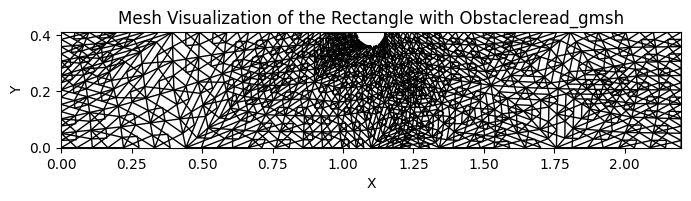

In [9]:
# Plot the mesh
plt.figure(figsize=(8, 6))
for element in element_nodes:
    triangle = node_coords[element, :2]  # Extract x, y coordinates of triangle's nodes
    polygon = plt.Polygon(triangle, edgecolor='black', fill=None)  # Create a polygon
    plt.gca().add_patch(polygon)

plt.xlim(0, canal_length)
plt.ylim(0, canal_height)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Mesh Visualization of the Rectangle with Obstacleread_gmsh")
plt.xlabel("X")
plt.ylabel("Y")

In [10]:
# --------------------------------------------------------------
# Finalize Gmsh
# --------------------------------------------------------------
if mesh_comm.rank == model_rank:
    gmsh.finalize()

In [11]:
if mesh_comm.rank == model_rank:
    mesh, cell_tags, facet_tags = gmshio.read_from_msh(mesh_file,mesh_comm, 0,gdim=2)


Info    : Reading 'mesh_with_obstacle_05_25.msh'...
Info    : 13 entities
Info    : 1329 nodes
Info    : 312 elements
Info    : Done reading 'mesh_with_obstacle_05_25.msh'


In [12]:
# Get the function space (for velocity in this case, assuming it's a flow problem)
#V = dolfinx.fem.VectorFunctionSpace(mesh, ("CG", 2))
v_cg2 = basix_element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = basix_element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

In [13]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [14]:
# functions to set dirichlet boundary conditions and inflow p
def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], canal_height))

def inflow(x):
    return np.isclose(x[0], 0)

def outflow(x):
    return np.isclose(x[0], canal_length)


In [15]:
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(pressure), inflow_dofs, Q)

outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(pressure-.5), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

In [16]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [17]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

#a1 = form([[inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
#L1 = form([inner(f, v) * dx, inner(Constant(mesh, PETSc.ScalarType(0)), q) * dx])  # type: ignore
# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx

In [18]:
a1 = form(lhs(F1))
L1 = form(rhs(F1))

In [19]:
A1 = assemble_matrix(a1, bcs=bcu) # type: ignore
A1.assemble()
b1 = create_vector(L1)

In [20]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

In [21]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

# play with accuracy of solvers, these are the defail values
# solver1.setTolerances(rtol=1e-5, atol=1e-50, divtol=1e5, max_it=1000)

In [22]:
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

In [24]:
# def u_exact(x):
#     values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
#     values[0] = 4 * x[1] * (1.0 - x[1])
#     return values
def u_exact(x):
    L = canal_length  # Length of the canal
    H = canal_height   # Height of the canal
    R = obstacle_radius # Radius of the semi-circular obstacle
    x0 = obstacle_center_x  # x-coordinate of the obstacle center
    y0 = obstacle_center_y  # y-coordinate of the obstacle center (top wall)

    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    # Calculate distance from obstacle center
    r = np.sqrt((x[0]-x0)**2 + (x[1]-y0)**2)
    
    # x-component of velocity
    values[0] = 4 * x[1] * (H - x[1]) / H**2 * (1 - np.exp(-x[0]/L)) * (1 - R**2 / (r**2 + 1e-10))
    
    # y-component of velocity (perturbation due to obstacle)
    values[1] = -0.1 * R**2 * (x[1]-y0) / (r**2 + 1e-10) * (x[0] - x0) / (np.abs(x[0] - x0) + 1e-10)
    
    # Set velocity to zero inside the obstacle
    inside_obstacle = (r < R) & (x[1] > y0 - R)
    values[0][inside_obstacle] = 0
    values[1][inside_obstacle] = 0
    
    return values

u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

In [26]:
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.vector.array - u_ex.vector.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

"""
0.02 dt
prev run: Time 0.01, L2-error 2.23e+02, Max error 8.00e+01
"""

Time 0.00, L2-error 2.79e-01, Max error 3.84e-03
Time 0.08, L2-error 2.76e-01, Max error 4.83e-03
Time 0.16, L2-error 2.76e-01, Max error 4.88e-03
Time 0.24, L2-error 2.76e-01, Max error 4.89e-03
Time 0.32, L2-error 2.76e-01, Max error 4.89e-03
Time 0.40, L2-error 2.76e-01, Max error 4.90e-03
Time 0.48, L2-error 2.76e-01, Max error 4.90e-03
Time 0.56, L2-error 2.76e-01, Max error 4.90e-03
Time 0.64, L2-error 2.76e-01, Max error 4.91e-03
Time 0.72, L2-error 2.76e-01, Max error 4.91e-03
Time 0.80, L2-error 2.76e-01, Max error 4.91e-03
Time 0.88, L2-error 2.76e-01, Max error 4.91e-03
Time 0.96, L2-error 2.76e-01, Max error 4.93e-03
Time 1.04, L2-error 2.76e-01, Max error 4.94e-03
Time 1.12, L2-error 2.76e-01, Max error 4.95e-03
Time 1.20, L2-error 2.76e-01, Max error 4.96e-03
Time 1.28, L2-error 2.76e-01, Max error 4.98e-03
Time 1.36, L2-error 2.76e-01, Max error 4.99e-03
Time 1.44, L2-error 2.76e-01, Max error 5.00e-03
Time 1.52, L2-error 2.76e-01, Max error 5.00e-03
Time 1.60, L2-error 

'\n0.02 dt\nprev run: Time 0.01, L2-error 2.23e+02, Max error 8.00e+01\n'

In [74]:
#from npy_append_array import NpyAppendArray
u_sub = u_n.sub(0)  # Normal component of velocity (u_x in 2D)

# Define a function space on the boundary (or use a test function for the integral)
dx = Measure("dx", domain=V.mesh)
x = SpatialCoordinate(V.mesh)
# Conditional integration over specific slices (beginning, middle, end)
beginning_slice = conditional(le(x[0], 0.0 + .01), 1, 0.0)  # Near x = 0
middle_slice = conditional(ge(x[0], obstacle_center_x - 1e-3), 1, 0.0) * conditional(le(x[0], obstacle_center_x + 1e-3), 1.0, 0.0)  # Near x = L/2
end_slice = conditional(ge(x[0], canal_length - 1e-2), 1, 0.0)  

# Mass flow rate at the beginning of the domain
mass_flow_beginning = assemble_scalar(form(u_sub * beginning_slice * dx))

# Mass flow rate at the middle of the domain
mass_flow_middle = assemble_scalar(form(u_sub * middle_slice * dx))

# Mass flow rate at the end of the domain
mass_flow_end = assemble_scalar(form(u_sub * end_slice * dx))

# Print the result (using MPI reduce for distributed computation)
#mass_flow_rate_global = MPI.COMM_WORLD.reduce(mass_flow_rate, op=MPI.SUM, root=0)
if MPI.COMM_WORLD.rank == 0:
    print("Mass flow rate x0:", mass_flow_beginning,
         "\nMass flow rate obstacle:", mass_flow_middle,
         "\nMass flow rate end-1:", mass_flow_end)
    #arr = [d_in, d_out, b_in, b_out, mesh_file, mass_flow_rate_global, error_L2, error_max]
    #y = np.load(filename+".npy") if os.path.isfile(filename+".npy") else np.save(filename+".npy")
    #np.save(filename+".npy",np.append(y,[arr])) #save the new

Mass flow rate x0: 0.06019281632596381 
Mass flow rate obstacle: 0.007870130583693596 
Mass flow rate end-1: 0.21411154877443184


In [31]:

# Get the minimum and maximum x-coordinates of the mesh
x_min = 0.15
x_max = mesh.geometry.x[:, 0].max()

# Define the interval for calculations
interval = 0.1

# Create lists to store the results
flow_results = []
pressure_results = []

# Extract the normal component of velocity (u_x in 2D)
u_sub = u_n.sub(0)

# Define measures and spatial coordinates
dx = Measure("dx", domain=mesh)
x = SpatialCoordinate(mesh)

# Loop through the x-coordinates at regular intervals
for x_pos in np.arange(x_min, x_max, interval):
    # Define a slice at the current x-coordinate
    slice_condition = conditional(ge(x[0], x_pos - 2.2e-2), 1.0, 0.0) * conditional(le(x[0], x_pos + 2.2e-2), 1.0, 0.0)
    
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))
    press = assemble_scalar(form(slice_condition * dx))
    # Calculate average pressure at the current slice
    pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
    
    # Append the results to the lists
    flow_results.append((x_pos, mass_flow))
    pressure_results.append((x_pos, pressure_avg))

# Communicate results across MPI processes
if MPI.COMM_WORLD.size > 1:
    flow_results = MPI.COMM_WORLD.allgather(flow_results)
    flow_results = [item for sublist in flow_results for item in sublist]
    pressure_results = MPI.COMM_WORLD.allgather(pressure_results)
    pressure_results = [item for sublist in pressure_results for item in sublist]

# Sort results by x-coordinate
flow_results.sort(key=lambda x: x[0])
pressure_results.sort(key=lambda x: x[0])



In [30]:
#print(flow_results)
#print(pressure_results)
#plt.plot(flow_results[1], flow_results[0])
pressure_results

[(0.15, 0.1776473149008827),
 (0.25, 0.2565333803147247),
 (0.35, 0.32955429774280753),
 (0.45000000000000007, 0.2787794132002673),
 (0.55, 0.22785329046874922),
 (0.65, 0.24761016259355267),
 (0.7500000000000001, 0.23639340572846493),
 (0.8500000000000001, 0.29504149261305607),
 (0.9500000000000001, 0.2356517977161687),
 (1.05, 0.2662349883542281),
 (1.15, 0.23995099136677958),
 (1.25, 0.2702881580812693),
 (1.35, 0.23722645415157834),
 (1.45, 0.27793277611615713),
 (1.55, 0.2452268037104612),
 (1.65, 0.24790194060842277),
 (1.75, 0.29562841886538516),
 (1.85, 0.27682899807208855),
 (1.95, 0.19026498103808256),
 (2.0500000000000003, 0.21677931061104377),
 (2.15, 0.30179550969136226)]

In [73]:
mfr_a = (canal_height*1)/(12*canal_length)
mfr_a

0.041666666666666664

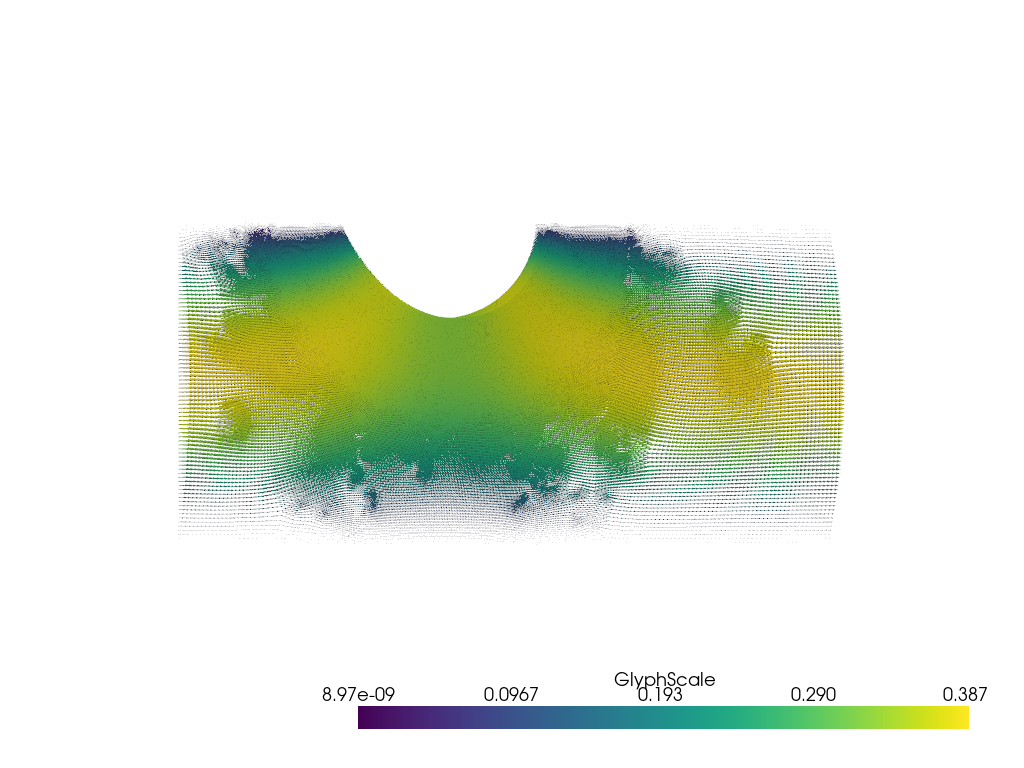

In [27]:
import pyvista
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.7)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter(notebook=True,line_smoothing=True,polygon_smoothing=True)
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
#plotter.window_size = [600, 400]
#plotter.set_scale(yscale=2,xscale=4)
plotter.view_xy()
plotter.save_graphic("o_c_4np.load(outfile)np.load(outfile).pdf",title='PyVista Export')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs2.pdf")

In [51]:
s = np.load("mfr_l2.npy")

In [52]:
s

array(['0.05', '0.25', '0.1', '0.5', 'mesh_with_obstacle_05_25.msh',
       '11.903145955863351', '1.129190240173156', '0.3862625161759905',
       '0.05', '0.25', '0.1', '0.5', 'mesh_with_obstacle_05_25.msh',
       '11.903145955863351', '1.129190240173156', '0.3862625161759905',
       '0.05', '0.25', '0.1', '0.5', 'mesh_with_obstacle_05_25.msh',
       '11.903145955863351', '1.129190240173156', '0.3862625161759905'],
      dtype='<U32')